In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


## Experiment 1

### Transforming & loading Data

In [3]:
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='data', train=True, transform=transf, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


### Setting Hyperparameters

In [2]:
torch.manual_seed(504)
np.random.seed(504)
z_dim = 100
batch_size = 64
learning_rate = 1e-4
epochs = 100
lam_gp = 10


### Defining Generator & Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


### Initialize Generator and Discriminator

In [6]:
gen = Generator(z_dim)
disc = Discriminator()

# Optimizing generator and discriminator
opt_G = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.9))
opt_D = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.9))


### Training

In [8]:
# Training loop
g_losses = []
d_losses = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        r_imgs = imgs
        opt_D.zero_grad()
        z = torch.randn(imgs.size(0), z_dim)
        fake_imgs = gen(z)

        real_validity = discriminator(r_imgs)
        fake_validity = discriminator(fake_imgs)

        grad_penalty = grad_penalty(discriminator, r_imgs.data, fake_imgs.data)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lam_gp * grad_penalty
        d_loss.backward()
        opt_D.step()
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), z_dim)
        f_imgs = gen(z)
        fake_val = discriminator(f_imgs)
        g_loss = -torch.mean(fake_val)
        g_loss.backward()
        opt_G.step()

        # Store loss values
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}')


Epoch [1/100] | D Loss: -7.9722 | G Loss: -0.1860
Epoch [2/100] | D Loss: -5.9456 | G Loss: 0.1556
Epoch [3/100] | D Loss: -8.1990 | G Loss: 5.7366
Epoch [4/100] | D Loss: -8.3618 | G Loss: 7.1529
Epoch [5/100] | D Loss: -8.1608 | G Loss: 7.6516
Epoch [6/100] | D Loss: -8.9232 | G Loss: 6.0032
Epoch [7/100] | D Loss: -7.7004 | G Loss: 5.2525
Epoch [8/100] | D Loss: -9.7789 | G Loss: 6.2410
Epoch [9/100] | D Loss: -8.3641 | G Loss: 4.3646
Epoch [10/100] | D Loss: -6.2403 | G Loss: 3.0569
Epoch [11/100] | D Loss: -7.7995 | G Loss: 3.9047
Epoch [12/100] | D Loss: -7.7552 | G Loss: 5.0266
Epoch [13/100] | D Loss: -7.2524 | G Loss: 4.4359
Epoch [14/100] | D Loss: -6.1361 | G Loss: 2.8777
Epoch [15/100] | D Loss: -5.1325 | G Loss: 2.1948
Epoch [16/100] | D Loss: -4.1751 | G Loss: 2.0743
Epoch [17/100] | D Loss: -3.9052 | G Loss: -1.6659
Epoch [18/100] | D Loss: -4.1597 | G Loss: 0.0442
Epoch [19/100] | D Loss: -3.4798 | G Loss: -1.3712
Epoch [20/100] | D Loss: -3.3618 | G Loss: -1.3402
Epoch

### Generating images and plotting

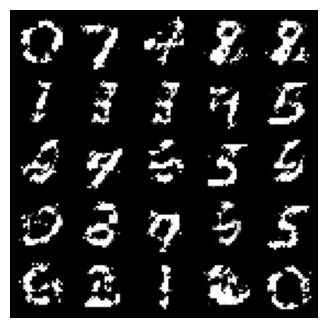

In [10]:
def gen_and_plot_images(gen, num_gen=25):
    z = torch.randn(num_gen, z_dim)
    gen_images = gen(z).detach().numpy()
    # Plotting the images
    h, w = 28, 28
    n = int(np.sqrt(num_gen))
    I_gen = np.empty((h*n, w*n))

    for i in range(n):
        for j in range(n):
            I_gen[i*h:(i+1)*h, j*w:(j+1)*w] = gen_images[i*n+j, 0]

    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(I_gen, cmap='gray')
    plt.show()
gen_and_plot_images(gen)


### Experiment 2

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
z_dim = 100
batch_size = 128
lr_gen = 1e-4   
lr_disc = 0.0001
epochs = 100
lambda_gp = 10

In [10]:
def grad_penalty(D, r_samples, f_samples):
    alph = torch.rand((r_samples.size(0), 1, 1, 1), device=r_samples.device)
    interpol = (alpha * r_samples + (1 - alph) * f_samples).requires_grad_(True)
    d_inter = D(interpol)
    fake = torch.ones(d_inter.shape, device=r_samples.device)
    grad = autograd.grad(
        outputs=d_interpol,
        inputs=interpol,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    grad = grad.view(grad.size(0), -1)
    grad_penalty = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty


In [42]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
t_dataset = datasets.MNIST(root='data', train=True, transform=trans, download=True)
t_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


### Initializing Generator & Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=4, stride=1, padding=0), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     
            nn.Tanh()  
        )
    
    def forward(self, z):
        out = self.model(z.view(-1, z_dim, 1, 1))
        return out[:, :, 2:30, 2:30]  

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0)
        )
    
    def forward(self, x):
        return self.model(x).view(-1, 1)  

### Initializing models

In [8]:
gen = Generator().to(device)
disc = Discriminator().to(device)

# Initialize optimizers
opt_G = optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5, 0.999))
opt_D = optim.Adam(disc.parameters(), lr=lr_disc, betas=(0.5, 0.999))


In [47]:
def save_gen_images(gen, epoch, z_dim, n_images=25, img_shape=(1, 28, 28)):
    z = torch.randn(n_images, z_dim, 1, 1).to(device)
    with torch.no_grad():
        gen_imgs = generator(z).cpu().numpy()

    # Rescaling images to [0, 1]
    generated_imgs = (gen_imgs + 1) / 2  
    g_size = int(np.sqrt(n_images))
    fig, axes = plt.subplots(g_size, g_size, figsize=(5, 5))
    axes = axes.flatten()

    for image, ax in zip(generated_imgs, axes):
        ax.imshow(image[0], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_images_epoch_{epoch+1}.png')
    plt.close()


### Training

In [48]:
g_losses = []
d_losses = []

for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    for i, (imgs, _) in enumerate(train_loader):
        r_imgs = imgs.to(device)
        opt_D.zero_grad()
        z = torch.randn(imgs.size(0), z_dim, 1, 1).to(device)
        f_imgs = gen(z)
        r_validity = disc(r_imgs)
        f_validity = disc(fake_imgs)

        # Loss calculation
        d_loss_real = -torch.mean(r_validity)
        d_loss_fake = torch.mean(f_validity)

        g_penalty = grad_penalty(disc, r_imgs.data, f_imgs.data)
        d_loss = d_loss_real + d_loss_fake + lam_gp * grad_penalty
        d_loss.backward()
        opt_D.step()

        # Training Generator
        opt_G.zero_grad()

        z = torch.randn(imgs.size(0), z_dim, 1, 1).to(device)
        f_imgs = gen(z)
        f_validity = disc(fake_imgs)

        # Generator loss
        g_loss = -torch.mean(fake_validity)  
        g_loss.backward()
        opt_G.step()

        # Storing loss values in thelist
        g_losses.append(g_loss.item())                                                                                                                                                                                                                                                                                                                                         
        d_losses.append(d_loss.item())

    # Saving images every 5 epochs
    if (epoch + 1) % 5 == 0:  
        save_gen_images(gen epoch, z_dim)
    print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}')


Epoch [1/100]
Epoch [1/100] | D Loss: -0.2436 | G Loss: 0.0197
Epoch [2/100]
Epoch [2/100] | D Loss: -0.0551 | G Loss: -0.0785
Epoch [3/100]
Epoch [3/100] | D Loss: -0.0528 | G Loss: 0.1298
Epoch [4/100]
Epoch [4/100] | D Loss: -0.0313 | G Loss: 0.0888
Epoch [5/100]
Epoch [5/100] | D Loss: -0.0363 | G Loss: 0.1363
Epoch [6/100]
Epoch [6/100] | D Loss: -0.0316 | G Loss: 0.0959
Epoch [7/100]
Epoch [7/100] | D Loss: -0.0246 | G Loss: 0.0821
Epoch [8/100]
Epoch [8/100] | D Loss: -0.0315 | G Loss: 0.0869
Epoch [9/100]
Epoch [9/100] | D Loss: -0.0311 | G Loss: 0.0508
Epoch [10/100]
Epoch [10/100] | D Loss: -0.0272 | G Loss: 0.1164
Epoch [11/100]
Epoch [11/100] | D Loss: -0.0302 | G Loss: 0.0931
Epoch [12/100]
Epoch [12/100] | D Loss: -0.0285 | G Loss: 0.0616
Epoch [13/100]
Epoch [13/100] | D Loss: -0.0273 | G Loss: 0.0285
Epoch [14/100]
Epoch [14/100] | D Loss: -0.0286 | G Loss: 0.0026
Epoch [15/100]
Epoch [15/100] | D Loss: -0.0294 | G Loss: 0.1025
Epoch [16/100]
Epoch [16/100] | D Loss: -0

### Saving model checkpoints after 100 epochs

In [56]:
torch.save({
    'epoch': num_epochs,  # Save number of completed epochs
    'generator_state_dict': gen.state_dict(),
    'discriminator_state_dict': disc.state_dict(),
    'optimizer_G_state_dict': opt_G.state_dict(),
    'opt_D_state_dict': opt_D.state_dict(),
}, 'wgan_checkpoint.pth')


### Load the saved model

In [57]:
checkpoint = torch.load('wgan_checkpoint.pth')
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
opt_D.load_state_dict(checkpoint['opt_D'])
start_epoch = checkpoint['epoch']


C:\Users\shrey\AppData\Local\Temp\ipykernel_43972\2028884967.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('wgan_checkpoint.pth')


### Continuing for 50 more epochs

In [58]:
new_epochs = 50
for epoch in range(start_epoch, start_epoch + new_epochs):
    print(f"Epoch [{epoch+1}/{start_epoch + new_epochs}]")
    for i, (imgs, _) in enumerate(t_loader):
        r_imgs = imgs.to(device)

        # Trainingk Discriminator
        opt_D.zero_grad()

        z = torch.randn(imgs.size(0), z_dim, 1, 1).to(device)
        f_imgs = gen(z)

        r_validity = disc(r_imgs)
        f_validity = discr(f_imgs)

        d_loss_real = -torch.mean(r_validity)
        d_loss_fake = torch.mean(f_validity)

        grad_penalty = grad_penalty(disc, r_imgs.data, fake_imgs.data)
        d_loss = d_loss_real + d_loss_fake + lambda_gp * grad_penalty
        d_loss.backward()
        opt_D.step()

        # Training Generator
        optimizer_G.zero_grad()

        z = torch.randn(imgs.size(0), z_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)

        g_loss = -torch.mean(f_validity)  
        g_loss.backward()
        opt_G.step()
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    if (epoch + 1) % 5 == 0:  
        save_generated_images(generator, epoch, z_dim)

    # Printing losses at the end of each epoch
    print(f'Epoch [{epoch+1}/{start_epoch + new_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}')
    
torch.save({
    'epoch': start_epoch + new_epochs,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'opt_D_state_dict': opt_D.state_dict(),
}, 'wgan_checkpoint_after_150.pth')


Epoch [101/150]
Epoch [101/150] | D Loss: -0.0330 | G Loss: 0.2760
Epoch [102/150]
Epoch [102/150] | D Loss: -0.0579 | G Loss: 0.2601
Epoch [103/150]
Epoch [103/150] | D Loss: -0.0320 | G Loss: 0.2116
Epoch [104/150]
Epoch [104/150] | D Loss: -0.0408 | G Loss: 0.1552
Epoch [105/150]
Epoch [105/150] | D Loss: -0.0200 | G Loss: 0.2738
Epoch [106/150]
Epoch [106/150] | D Loss: -0.0388 | G Loss: 0.1706
Epoch [107/150]
Epoch [107/150] | D Loss: -0.0376 | G Loss: 0.2489
Epoch [108/150]
Epoch [108/150] | D Loss: -0.0314 | G Loss: 0.2543
Epoch [109/150]
Epoch [109/150] | D Loss: -0.0373 | G Loss: 0.2574
Epoch [110/150]
Epoch [110/150] | D Loss: -0.0433 | G Loss: 0.2681
Epoch [111/150]
Epoch [111/150] | D Loss: -0.0480 | G Loss: 0.2389
Epoch [112/150]
Epoch [112/150] | D Loss: -0.0419 | G Loss: 0.3063
Epoch [113/150]
Epoch [113/150] | D Loss: -0.0290 | G Loss: 0.2027
Epoch [114/150]
Epoch [114/150] | D Loss: -0.0494 | G Loss: 0.2780
Epoch [115/150]
Epoch [115/150] | D Loss: -0.0541 | G Loss: 0.

In [11]:
checkpoint = torch.load('wgan_checkpoint_after_150.pth')
gen.load_state_dict(checkpoint['generator_state_dict'])
disc.load_state_dict(checkpoint['discriminator_state_dict'])
opt_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
opt_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
start_epoch = checkpoint['epoch']


C:\Users\shrey\AppData\Local\Temp\ipykernel_6980\4256505268.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('wgan_checkpoint_after_150.pth')


In [12]:
checkpoint = torch.load('wgan_checkpoint_after_150.pth')

# Load the generator's state_dict from the checkpoint
gen.load_state_dict(checkpoint['generator_state_dict'])
print("Generator loaded successfully!")

Generator loaded successfully!


C:\Users\shrey\AppData\Local\Temp\ipykernel_6980\1203902382.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('wgan_checkpoint_after_150.pth')


### Saving Generator Model and Weights

In [66]:
import json
gen_json = gen.__repr__()
with open("generator.json", "w") as json_file:
    json.dump(gen_json, json_file)

# Saving the weights
torch.save(generator.state_dict(), "generator.h5")


### Visualization

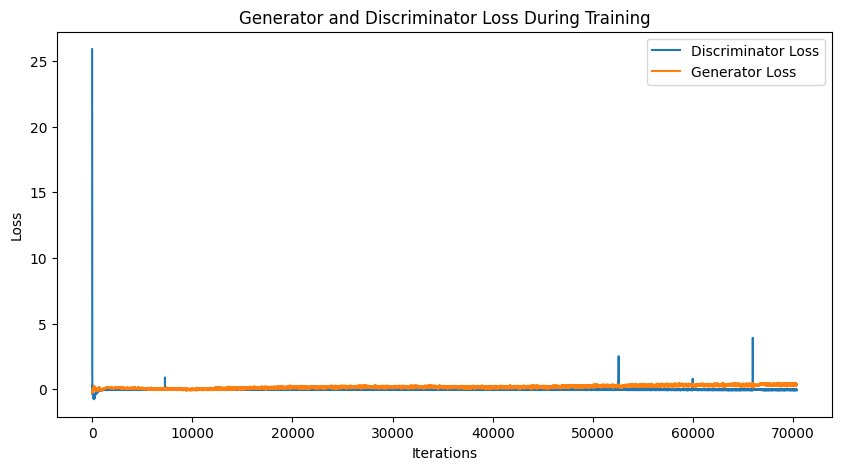

In [60]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title("Generator and Discriminator Loss During Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


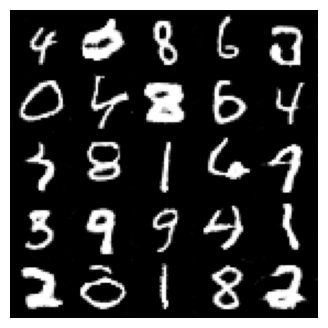

In [79]:
def gen_and_plot_images(gen, num_gen=25):
    z = torch.randn(num_gen, z_dim)
    gen_images = generator(z).detach().numpy()
    # Plotting the images
    h, w = 28, 28
    n = int(np.sqrt(num_gen))
    I_gen = np.empty((h*n, w*n))

    for i in range(n):
        for j in range(n):
            I_gen[i*h:(i+1)*h, j*w:(j+1)*w] = gen_images[i*n+j, 0]

    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(I_gen, cmap='gray')
    plt.show()
gen_and_plot_images(generator)


### Plotting 0-9 digit once

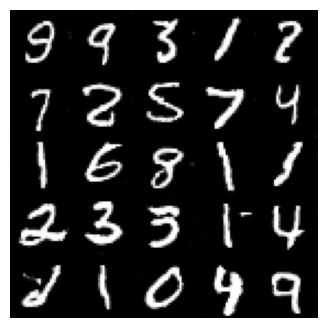

In [208]:
import torch
import numpy as np
import matplotlib.pyplot as plt
generator.eval()
np.random.seed(504)
z_dim = 100
num_gen = 25  
h = w = 28  

# Generating latent vectors
z = torch.randn(num_gen, z_dim, 1, 1).to(device)
generated_images = generator(z).detach().cpu().numpy()

# Ensuring the images are in the right shape 
generated_images = np.squeeze(generated_images, axis=1)
n = int(np.sqrt(num_gen))
I_generated = np.empty((h * n, w * n))

for i in range(n):
    for j in range(n):
        I_generated[i * h:(i + 1) * h, j * w:(j + 1) * w] = generated_images[i * n + j, :].reshape(28, 28)
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(I_generated, cmap='gray')
plt.show()
